In [1]:
import os

%pip install -U numpy
import numpy as np
#print(np.__version__)
#%pip uninstall numpy -y
#%pip install numpy==1.26.4
#print(np.__version__)

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
import math
from sklearn.model_selection import train_test_split
%pip install shap==0.38.1

1.26.4
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl (13.7 MB)
Note: you may need to restart the kernel to use updated packages.
1.26.4
Note: you may need to restart the kernel to use updated packages.


### Load all the individual HUPA00xx.csv into df1, df2, etc.

In [12]:
# Set the directory path where the CSV files are located
dir_path = "Preprocessed"

# Create an empty list to store the dataframes
dfs = []

# Iterate over the files in the directory
for i in range(1, 26):
    # Construct the file name with zero-padding
    file_name = f"HUPA{str(i).zfill(4)}P.csv"
    
    # Join the directory path and file name
    file_path = os.path.join(dir_path, file_name)
    
    # Load the CSV file into a dataframe
    df = pd.read_csv(file_path, sep=";")
    
    # Append the dataframe to the list
    dfs.append(df)

# Assign the dataframes to individual variables
for i, df in enumerate(dfs, start=1):
    globals()[f"df{i}"] = df

In [13]:
from copy import deepcopy
df1copy = df1.copy(deep=True)
df1

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
0,2018-06-13T18:40:00,332.000000,6.3595,82.322835,34.0,0.091667,0.0,0.0
1,2018-06-13T18:45:00,326.000000,7.7280,83.740157,0.0,0.091667,0.0,0.0
2,2018-06-13T18:50:00,330.000000,4.7495,80.525180,0.0,0.091667,0.0,0.0
3,2018-06-13T18:55:00,324.000000,6.3595,89.129032,20.0,0.091667,0.0,0.0
4,2018-06-13T19:00:00,306.000000,5.1520,92.495652,0.0,0.075000,0.0,0.0
...,...,...,...,...,...,...,...,...
4091,2018-06-27T23:35:00,323.666667,5.2325,88.051724,0.0,0.058333,1.0,0.0
4092,2018-06-27T23:40:00,325.333333,4.1055,77.680672,0.0,0.058333,0.0,0.0
4093,2018-06-27T23:45:00,327.000000,4.0250,79.358974,0.0,0.058333,0.0,0.0
4094,2018-06-27T23:50:00,326.000000,4.1055,82.058333,0.0,0.058333,0.0,0.0


### Plot glucose levels and bolus insulin doses

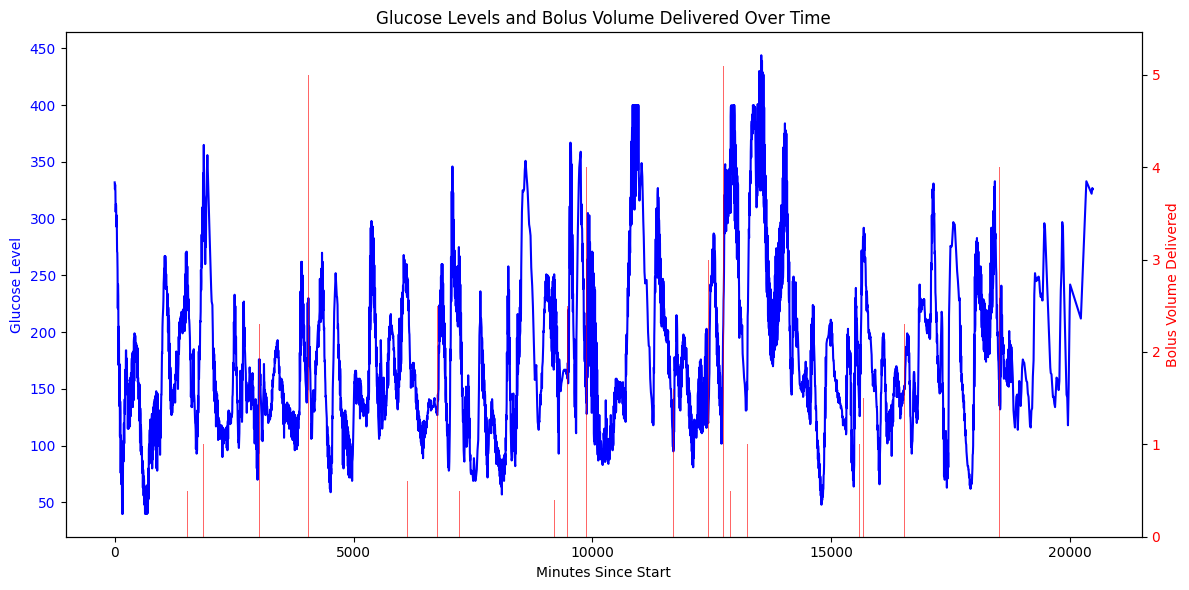

In [4]:
# Ensure 'time' column is in datetime format
df1['time'] = pd.to_datetime(df1['time'], errors='coerce')

# Check if the conversion was successful
if df1['time'].isnull().any():
    print("Warning: Some time values could not be converted to datetime.")

# Calculate the minutes since the first time point
df1['minutes_since_start'] = (df1['time'] - df1['time'].iloc[0]).dt.total_seconds() / 60

# Create a figure and axis for glucose levels
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot glucose levels on the left y-axis
ax1.plot(df1['minutes_since_start'], df1['glucose'], label='Glucose Level', color='blue')
ax1.set_xlabel('Minutes Since Start')
ax1.set_ylabel('Glucose Level', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin axis that shares the same x-axis for bolus_volume_delivered
ax2 = ax1.twinx()
ax2.bar(df1['minutes_since_start'], df1['bolus_volume_delivered'], width=5, color='red', alpha=0.6, label='Bolus Volume Delivered')

# Set the right y-axis label for bolus volume
ax2.set_ylabel('Bolus Volume Delivered', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the title
plt.title('Glucose Levels and Bolus Volume Delivered Over Time')

# Show the plot 
fig.tight_layout()  # Adjust the layout to ensure both y-axes are visible
plt.show()

### Add basal insulin infusion to the graph

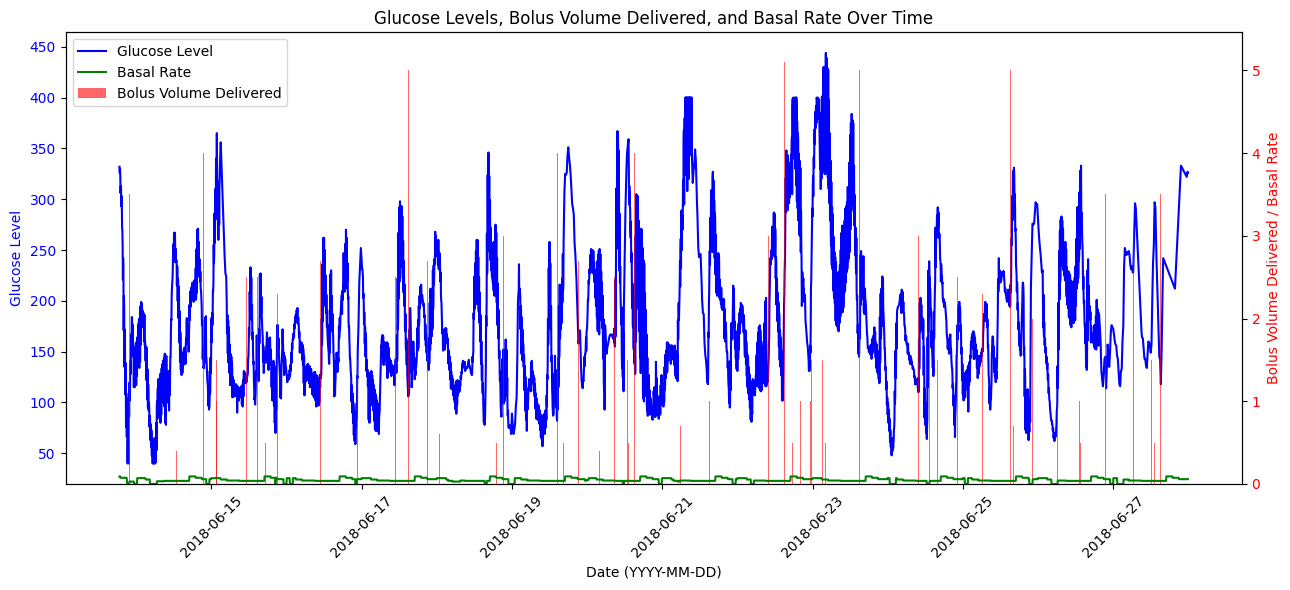

In [5]:
import matplotlib.dates as mdates

# Ensure 'time' column is in datetime format
df1['time'] = pd.to_datetime(df1['time'], errors='coerce')

# Check if the conversion was successful
if df1['time'].isnull().any():
    print("Warning: Some time values could not be converted to datetime.")

# Plotting
fig, ax1 = plt.subplots(figsize=(13, 6))

# Plot glucose levels on the left y-axis
ax1.plot(df1['time'], df1['glucose'], label='Glucose Level', color='blue')
ax1.set_xlabel('Date (YYYY-MM-DD)')
ax1.set_ylabel('Glucose Level', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format the x-axis to show year-month-day
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Create a twin axis that shares the same x-axis for bolus volume and basal rate
ax2 = ax1.twinx()

# Plot bolus_volume_delivered as red bars on the right y-axis
ax2.bar(df1['time'], df1['bolus_volume_delivered'], width=0.01, color='red', alpha=0.6, label='Bolus Volume Delivered')

# Plot basal_rate as a green line on the same right y-axis
ax2.plot(df1['time'], df1['basal_rate'], label='Basal Rate', color='green')

# Set the right y-axis label for bolus volume and basal rate
ax2.set_ylabel('Bolus Volume Delivered / Basal Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the title
plt.title('Glucose Levels, Bolus Volume Delivered, and Basal Rate Over Time')

# Create a combined legend for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()  # For glucose line
lines_2, labels_2 = ax2.get_legend_handles_labels()  # For bolus bars and basal rate line
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show the plot 
fig.tight_layout()  # Adjust the layout to ensure both y-axes are visible
plt.show()


### Add calorie intake to the graph

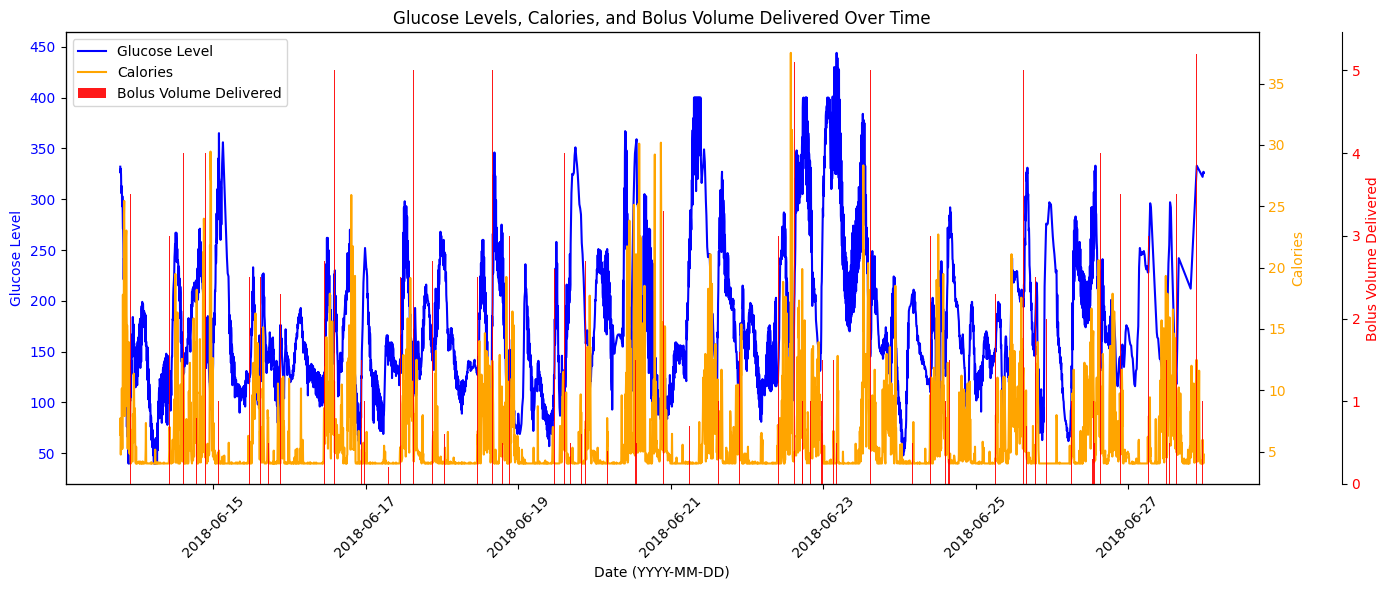

In [6]:
# Ensure 'time' column is in datetime format
df1['time'] = pd.to_datetime(df1['time'], errors='coerce')

# Check if the conversion was successful
if df1['time'].isnull().any():
    print("Warning: Some time values could not be converted to datetime.")

# Create the figure and the first axis for glucose levels
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot glucose levels on the left y-axis (ax1)
ax1.plot(df1['time'], df1['glucose'], label='Glucose Level', color='blue')
ax1.set_xlabel('Date (YYYY-MM-DD)')
ax1.set_ylabel('Glucose Level', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format the x-axis to show year-month-day
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Create a second y-axis (ax2) for calories
ax2 = ax1.twinx()
ax2.plot(df1['time'], df1['calories'], label='Calories', color='orange')
ax2.set_ylabel('Calories', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Create a third y-axis (ax3) for bolus_volume_delivered, offset on the right
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to the right
ax3.bar(df1['time'], df1['bolus_volume_delivered'], width=0.01, color='red', alpha=0.9, label='Bolus Volume Delivered')
ax3.set_ylabel('Bolus Volume Delivered', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Set the title
plt.title('Glucose Levels, Calories, and Bolus Volume Delivered Over Time')

# Create a combined legend for all axes
lines_1, labels_1 = ax1.get_legend_handles_labels()  # Glucose line
lines_2, labels_2 = ax2.get_legend_handles_labels()  # Calories line
lines_3, labels_3 = ax3.get_legend_handles_labels()  # Bolus bars
ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left')

# Show the plot
fig.tight_layout()  # Adjust the layout to ensure all three y-axes are visible
plt.show()

### Use transformer model to predict glucose level

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Dataset Class
class GlucoseDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __getitem__(self, idx):
        seq = torch.tensor(self.data.iloc[idx:idx + self.seq_len].values).float()  # Convert to Float32
        label = torch.tensor(self.data.iloc[idx + self.seq_len:idx + self.seq_len + self.pred_len].values).float()  # Convert to Float32
        return seq, label

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len

class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super(CustomTransformerEncoderLayer, self).__init__(*args, **kwargs)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # src2 is the output of the multi-head attention, attn_weights is the attention matrix
        src2, attn_weights = self.self_attn(src, src, src, attn_mask=src_mask,
                                            key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        # Return the attention weights without flattening them
        return src, attn_weights  # attn_weights shape: (batch_size, num_heads, seq_len, seq_len)

# Transformer-based Model for Glucose Prediction
class GlucoseTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, seq_len, pred_len, num_heads, dropout):
        super(GlucoseTransformer, self).__init__()
        self.embed_dim = 16
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_layers = 3  # You can adjust the number of layers

        self.input_linear = nn.Linear(input_dim, self.embed_dim)

        self.encoder_layers = nn.ModuleList([
            CustomTransformerEncoderLayer(d_model=self.embed_dim, nhead=num_heads, dim_feedforward=256, dropout=dropout)
            for _ in range(self.num_layers)
        ])

        self.fc = nn.Linear(self.embed_dim, output_dim)

    def forward(self, x, num_heads):
        # Linear projection of the input
        x = self.input_linear(x)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, embed_dim) -> (seq_len, batch_size, embed_dim)

        attention_weights_list = []
        
        # Pass through each encoder layer and collect attention weights
        for layer in self.encoder_layers:
            x, attn_weights = layer(x)
            attention_weights_list.append(attn_weights)  # Do not flatten

        # Extract the last 'pred_len' time steps and apply the final linear layer
        out = x[-self.pred_len:, :, :]  # (pred_len, batch_size, embed_dim)
        out = out.permute(1, 0, 2)  # (batch_size, pred_len, embed_dim)
        out = self.fc(out)  # (batch_size, pred_len, output_dim)

        # Stack the attention weights from each layer along a new dimension (dim=1)
        attention_weights = torch.stack(attention_weights_list, dim=1)  # Shape: (batch_size, num_layers, num_heads, seq_len, seq_len)

        return out, attention_weights

# Data Preparation
data = df1["glucose"]

# Normalize data
data = (data - data.mean()) / data.std()

# Split data into training and testing sets
train_data, test_data = data[:int(0.8 * len(data))], data[int(0.8 * len(data)):]

# Create dataset and data loader
seq_len = 30
pred_len = 6
batch_size = 32
num_heads=8

train_dataset = GlucoseDataset(train_data, seq_len=seq_len, pred_len=pred_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = GlucoseDataset(test_data, seq_len=seq_len, pred_len=pred_len)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, optimizer, and loss function
model = GlucoseTransformer(input_dim=1, output_dim=1, seq_len=seq_len, pred_len=pred_len, num_heads=num_heads, dropout=0.1)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train model
epochs = 50

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        seq, label = batch
        seq, label = seq.unsqueeze(-1).to(device), label.unsqueeze(-1).to(device)

        optimizer.zero_grad()
        output, all_attention_weights = model(seq, num_heads=num_heads)  # Pass num_heads and obtain attention weights
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}')

Epoch 1, Loss: 0.24359246350678743
Epoch 2, Loss: 0.21127761681290233
Epoch 3, Loss: 0.20360189504629256
Epoch 4, Loss: 0.2022166247753536
Epoch 5, Loss: 0.19883284045785082
Epoch 6, Loss: 0.19757689192306763
Epoch 7, Loss: 0.19611040656180942
Epoch 8, Loss: 0.1913762990312249
Epoch 9, Loss: 0.19538694320648325
Epoch 10, Loss: 0.19375777471007086
Epoch 11, Loss: 0.19009991713306484
Epoch 12, Loss: 0.1898659079098234
Epoch 13, Loss: 0.1919871357580026
Epoch 14, Loss: 0.18616464018237358
Epoch 15, Loss: 0.18151919295390448
Epoch 16, Loss: 0.1812262461319858
Epoch 17, Loss: 0.17614037265964583
Epoch 18, Loss: 0.17552189295198403
Epoch 19, Loss: 0.17085939733421102
Epoch 20, Loss: 0.17287318203963487
Epoch 21, Loss: 0.1706123920340164
Epoch 22, Loss: 0.16615965399964183
Epoch 23, Loss: 0.16587035496737443
Epoch 24, Loss: 0.16515643989630774
Epoch 25, Loss: 0.16264491652448973
Epoch 26, Loss: 0.16093580790010154
Epoch 27, Loss: 0.15812309751031445
Epoch 28, Loss: 0.15701491984666563
Epoch 2

### Plot the result

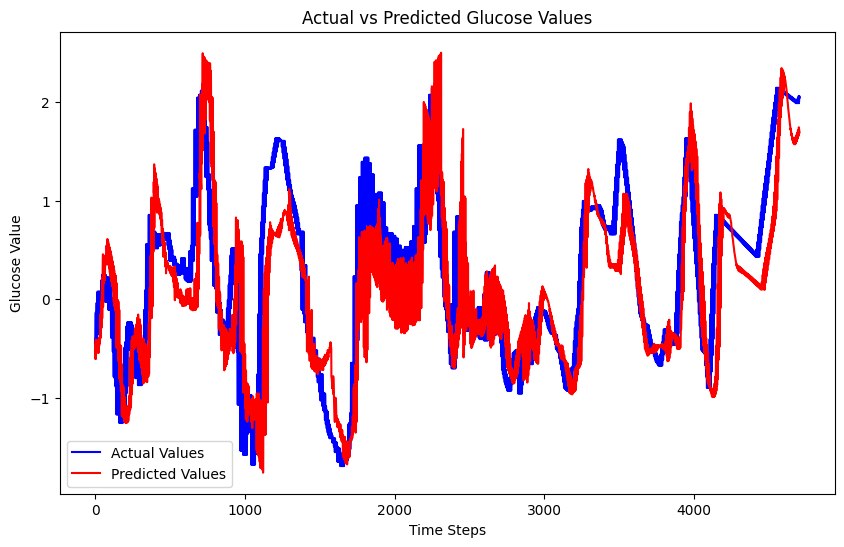

In [8]:
# Switch to evaluation mode
model.eval()

# Lists to store actual and predicted values
actual_values = []
predicted_values = []

with torch.no_grad():  # Disable gradient computation for evaluation
    for batch in test_loader:
        seq, label = batch
        seq, label = seq.unsqueeze(-1).to(device), label.unsqueeze(-1).to(device)

        # Get predictions
        predictions, _ = model(seq, num_heads=num_heads)

        # Add the actual and predicted values to their lists
        actual_values.append(label.squeeze(-1).cpu().numpy())
        predicted_values.append(predictions.squeeze(-1).cpu().numpy())

# Concatenate the values from all batches
actual_values = torch.cat([torch.tensor(x) for x in actual_values], dim=0)
predicted_values = torch.cat([torch.tensor(x) for x in predicted_values], dim=0)

# Plotting the actual vs. predicted glucose values
plt.figure(figsize=(10, 6))

# Select the first set of actual and predicted values for plotting (for clarity)
plt.plot(actual_values[:len(predicted_values)].flatten(), label='Actual Values', color='blue')
plt.plot(predicted_values.flatten(), label='Predicted Values', color='red')

plt.title('Actual vs Predicted Glucose Values')
plt.xlabel('Time Steps')
plt.ylabel('Glucose Value')
plt.legend()

# Show the plot
plt.show()

In [9]:
df1copy.head()

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
0,2018-06-13T18:40:00,332.0,6.3595,82.322835,34.0,0.091667,0.0,0.0
1,2018-06-13T18:45:00,326.0,7.7280,83.740157,0.0,0.091667,0.0,0.0
2,2018-06-13T18:50:00,330.0,4.7495,80.525180,0.0,0.091667,0.0,0.0
3,2018-06-13T18:55:00,324.0,6.3595,89.129032,20.0,0.091667,0.0,0.0
4,2018-06-13T19:00:00,306.0,5.1520,92.495652,0.0,0.075000,0.0,0.0


### Use Random Forest classifier to identify most important features

glucose                   float64
calories                  float64
heart_rate                float64
steps                     float64
basal_rate                float64
bolus_volume_delivered    float64
carb_input                float64
hour                        int32
day_of_week                 int32
day_of_month                int32
month                       int32
is_weekend                  int64
dtype: object
glucose                   0
calories                  0
heart_rate                0
steps                     0
basal_rate                0
bolus_volume_delivered    0
carb_input                0
hour                      0
day_of_week               0
day_of_month              0
month                     0
is_weekend                0
dtype: int64
Feature importances: [0.04309839 0.15543828 0.01737955 0.15635238 0.00281632 0.00035673
 0.30099995 0.10648725 0.19971224 0.         0.0173589 ]


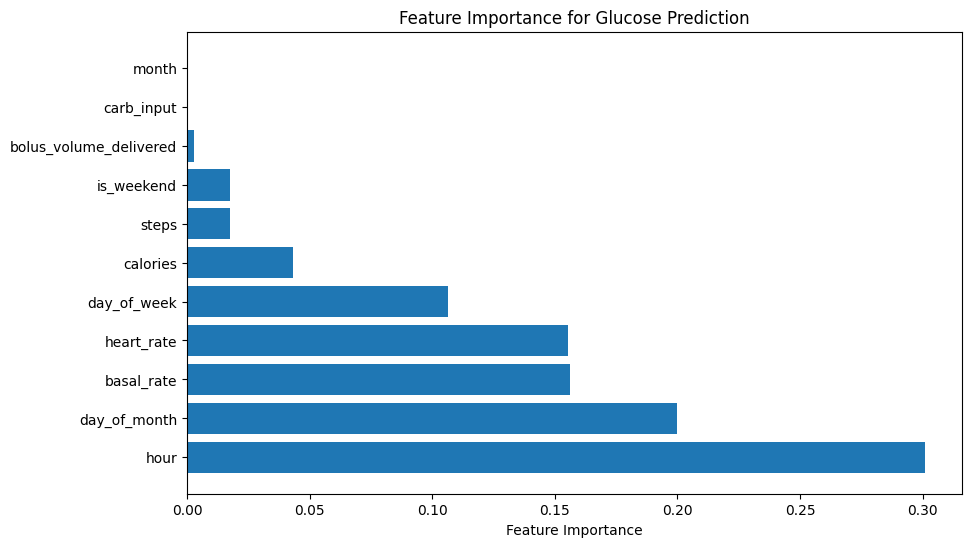

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Restore df1 as it was originally
df1 = df1copy.copy(deep=True)

# Convert 'time' column to a datetime object
df1['timestamp'] = pd.to_datetime(df1['time'])  # Fixed this line

# Extract useful features from the datetime column
df1['hour'] = df1['timestamp'].dt.hour
df1['day_of_week'] = df1['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
df1['day_of_month'] = df1['timestamp'].dt.day
df1['month'] = df1['timestamp'].dt.month
df1['is_weekend'] = (df1['timestamp'].dt.dayofweek >= 5).astype(int)  # Convert to int (0 or 1)

# Drop original 'time' and 'timestamp' columns
df1 = df1.drop(columns=['time', 'timestamp'])

# Check if there are any non-numeric columns left (this will display the data types)
print(df1.dtypes)

# Check for any missing values
print(df1.isnull().sum())

# Handle missing values if necessary (e.g., through imputation or dropping rows)
# df1 = df1.dropna()  # Example approach to drop missing rows (if applicable)

# Separate features (X) and target (y)
X = df1.drop(columns=['glucose'])  # Features (excluding glucose)
y = df1['glucose']  # Target (glucose levels)

# Train a Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X, y)

# Get feature importances
importances = model_rf.feature_importances_

# Print feature importances
print("Feature importances:", importances)

# Plot feature importances
feature_names = X.columns
importance_df = pd.DataFrame({'Features': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Glucose Prediction')
plt.show()

In [15]:
print(all_attention_weights.shape)

torch.Size([8, 3, 30, 30])


### Plot the attention weights for each of the 3 layers

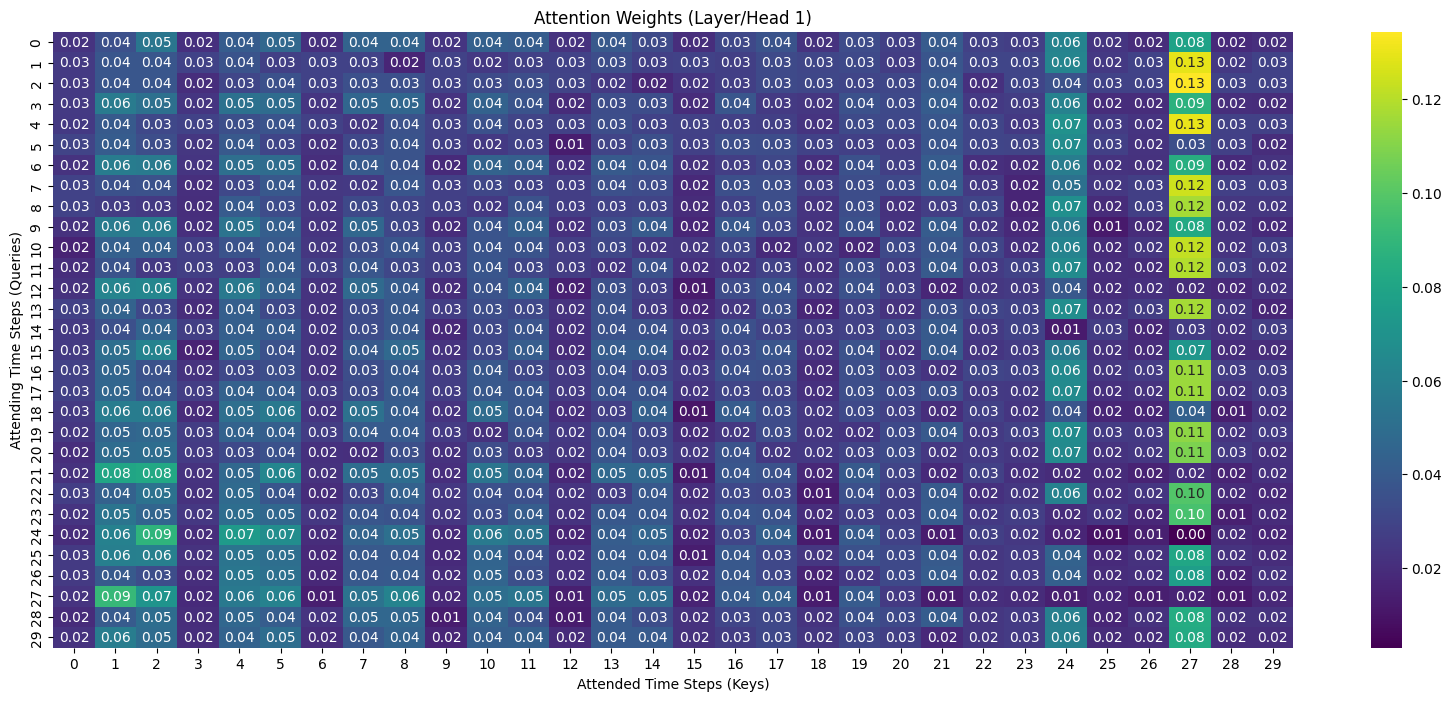

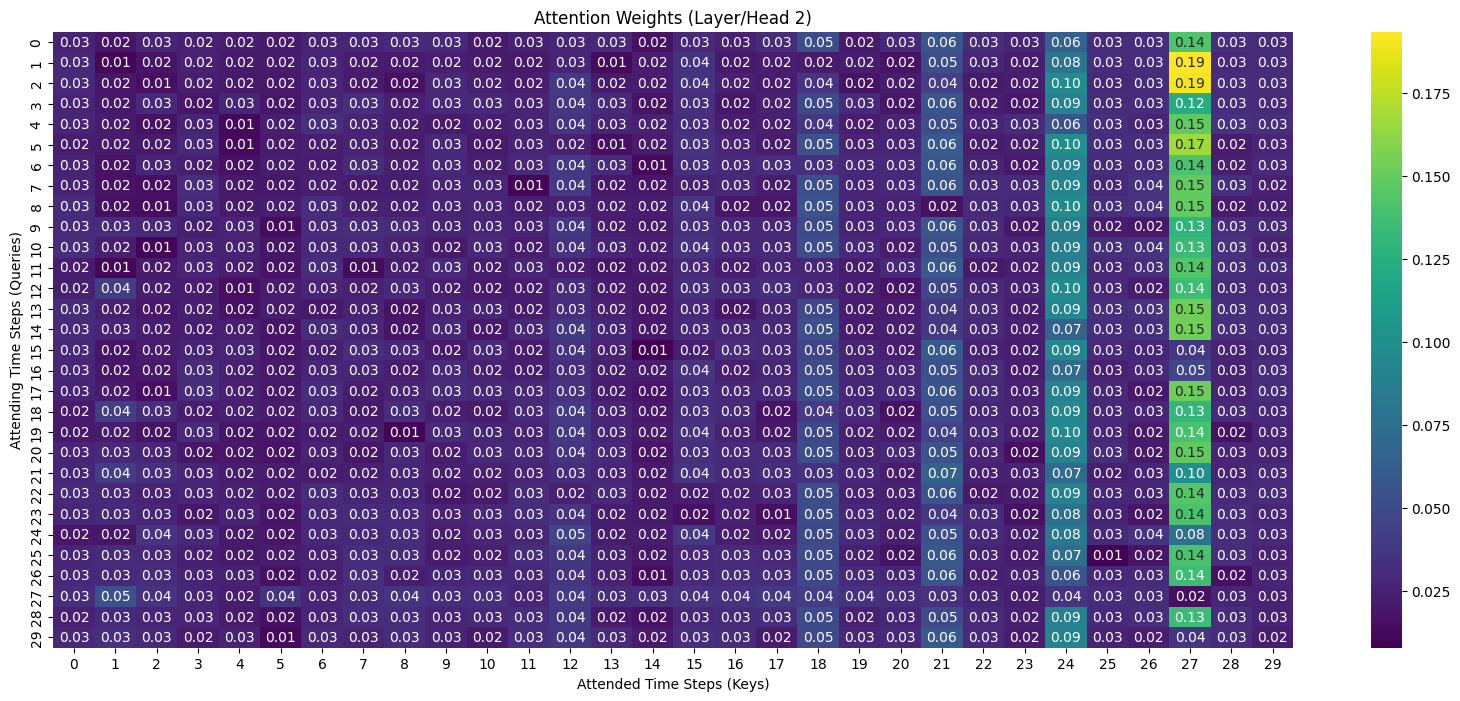

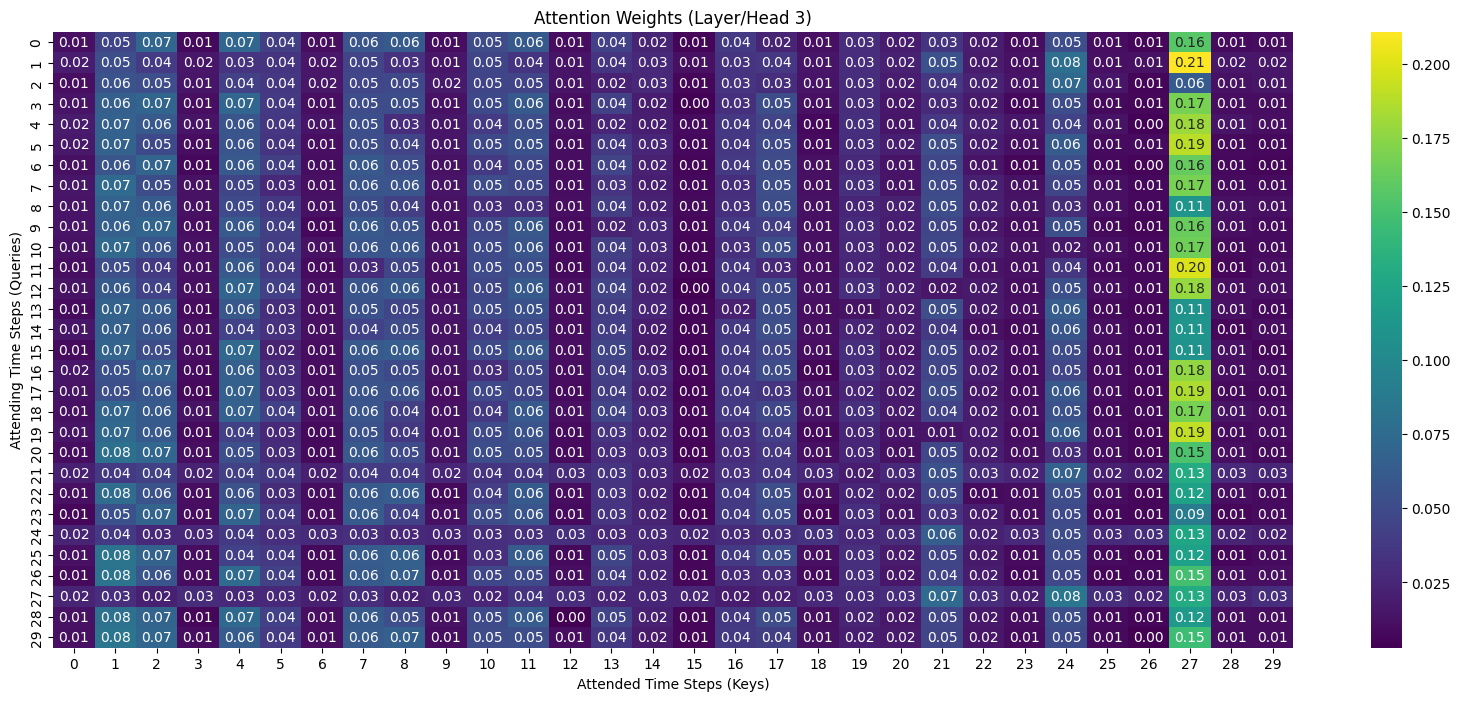

In [16]:
import seaborn as sns

# Select the attention weights for the last sample in the batch
attention_weights = all_attention_weights[-1]  # Shape: (3, 30, 30) for this sample

# Get the number of layers/heads and sequence length from the shape of attention_weights
num_layers_or_heads = attention_weights.shape[0]  # This is either layers or heads
seq_len = attention_weights.shape[1]              # This is the sequence length (30)

# Assuming 'time_steps' is a sequence of integers or labels for the x and y axes
time_steps = list(range(seq_len))  # Ensure this is of length 30

# Plot the heatmap for each attention head/layer
for layer_or_head in range(num_layers_or_heads):
    plt.figure(figsize=(20, 8))
    
    # Correct indexing: attention_weights[layer_or_head] is already (30, 30)
    attention_weights_numpy = attention_weights[layer_or_head].detach().cpu().numpy()
    
    # Plot the heatmap for this layer/head
    sns.heatmap(attention_weights_numpy, annot=True, cmap='viridis', fmt=".2f", 
                xticklabels=time_steps, yticklabels=time_steps)
    
    plt.title(f'Attention Weights (Layer/Head {layer_or_head+1})')
    plt.xlabel('Attended Time Steps (Keys)')
    plt.ylabel('Attending Time Steps (Queries)')
    plt.show()